In [1]:
from collections import OrderedDict
import pandas as pd
import nltk
import re
import matplotlib.pyplot as plt
from nltk.corpus import wordnet as wn
from operator import itemgetter
from wordcloud import WordCloud
import numpy as np
import pickle


In [2]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/tylermunyon/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
#load pickle file of custom stopwords
with open('custom_stop.txt', 'rb') as f:
    custom_stop = pickle.load(f)

In [4]:
#load pickle file of keyphrases list
with open('ordered_keyphrases.txt', 'rb') as f:
    ordered_keyphrases = pickle.load(f)

In [5]:
def tokenize_only(text):
    """
    tokenize by sentence, then by word to ensure that punctuation is caught as it's own token.
    """

   
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            if token != 's':
                filtered_tokens.append(token)
    return filtered_tokens

In [6]:
def make_wordcloud(dict, title):
    """
    create a word cloud, and title it with the input text.
    
    """
    d = dict
    wordcloud = WordCloud(width = 400, height = 300, max_font_size = 100, max_words = 10, background_color = 'white', colormap = "twilight")
    wordcloud.generate_from_frequencies(frequencies=d)

    plt.figure(figsize= (10, 10))
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis("off")
    plt.margins(x=0, y=0)
    plt.title(title)
   
    plt.show()

In [7]:
def phrase_voter(doc, return_dict = False):
    
    """
    1. Tokenizes doc with tokenize_only function. 
    
    2. Iterates through the tokens, and finds the phrase that it has the most in common with,
    the phrase with the highest, combined similarity recieves this tokens vote.
    MAKE SURE KEY PHRASES ARE ORDERED FROM MOST LIKELY TO LEAST LIKELY, AS THE FIRST ONES ARE FAVORED. 
    
    3. Returns either a wordcloud, or a dictionary of the top 10 key phrases, depending on whether return_dict is set = True. 
    
    """
    voters = tokenize_only(doc)
    
    keyphrase_votes = {}
    tokens = [token for token in voters if token not in custom_stop]
    
    #iterate though the tokens
    for token in tokens:
        first_phrase_choice = ''
        second_phrase_choice = ''
        third_phrase_choice = ''
        first_choice_value = 0
        second_choice_value = 0
        third_choice_value = 0
        #for each token, iterate though the phrases
        for phrase in ordered_keyphrases:
            #reset similarity value to 0
            phrase_similarity = 0
            #for each word in that phrase, find the senses with the greatest similarity to the token
            for keyword in phrase:
                word_similarity = 0
                if keyword not in wn.words():
                    word_similarity = 2 if keyword == token else 0
                #for each sense of token and keyword, find the similarity
                for i, j in enumerate(wn.synsets(token)):
                    for m, n in enumerate(wn.synsets(keyword)):
                        similarity = j.path_similarity(n)
                        similarity = 0 if similarity is None else similarity
                        
                        #reassign word_similarity with the highest similarity value
                        word_similarity = similarity if similarity > word_similarity else word_similarity
                
                #once i've gotten the highest similarity value possible for that keyword add that value to the total phrase_similarity
                phrase_similarity += word_similarity
                
            #if the phrase has a higher similarity than the previous phrases, make it the chosen_phrase and reassign the chosen phrase value
            phrase_similarity = phrase_similarity/len(phrase)
            joined_phrase = ' '.join(phrase)
            
            if phrase_similarity > first_choice_value:
                first_choice_value = phrase_similarity
                first_phrase_choice = joined_phrase
            elif phrase_similarity > second_choice_value:
                second_choice_value = phrase_similarity
                second_phrase_choice = joined_phrase
            elif phrase_similarity > third_choice_value:
                third_choice_value = phrase_similarity
                third_phrase_choice = joined_phrase
            else:
                continue
                
        #adjust value of chosen phrase, or if it's not already in the dictionary, add it with its value
        if first_phrase_choice in keyphrase_votes.keys():
            keyphrase_votes[first_phrase_choice] += first_choice_value
        else:
            keyphrase_votes[first_phrase_choice] = first_choice_value
            
        if second_phrase_choice in keyphrase_votes.keys():
            keyphrase_votes[second_phrase_choice] += second_choice_value
        else:
            keyphrase_votes[second_phrase_choice] = second_choice_value
        
        if third_phrase_choice in keyphrase_votes.keys():
            keyphrase_votes[third_phrase_choice] += third_choice_value
        else:
            keyphrase_votes[third_phrase_choice] = third_choice_value
         
        
    #once its through all of the tokens, return a sorted dictionary of the phrases and their votes
    sorted_dict = OrderedDict(sorted(keyphrase_votes.items(), key=itemgetter(1), reverse = True))
    topn_list = list(sorted_dict.items())[:10]
    topn_dict = dict(topn_list)
    
    if return_dict == True: 
        return topn_dict
    else:
        make_wordcloud(topn_dict, doc)


    

In [15]:
test = 'ate apples and peanut butter'

In [9]:
wn.synsets('dog')

[Synset('dog.n.01'),
 Synset('frump.n.01'),
 Synset('dog.n.03'),
 Synset('cad.n.01'),
 Synset('frank.n.02'),
 Synset('pawl.n.01'),
 Synset('andiron.n.01'),
 Synset('chase.v.01')]

In [10]:
wn.words

<bound method WordNetCorpusReader.words of <WordNetCorpusReader in '/Users/tylermunyon/nltk_data/corpora/wordnet'>>

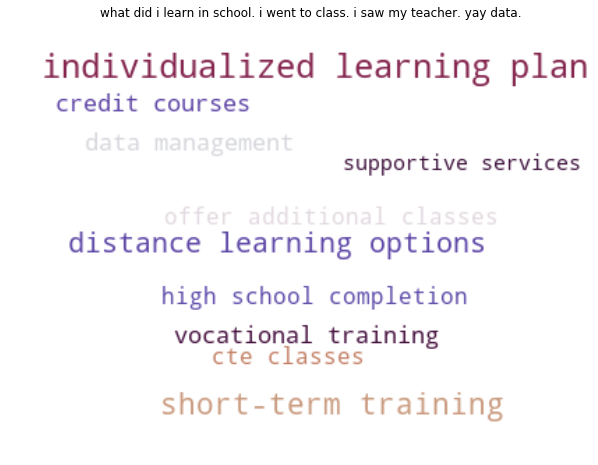

In [11]:
phrase_voter(test)

In [14]:
phrase_voter(test, return_dict=True)

{'individualized learning plan': 0.4666666666666666,
 'supportive services': 0.45,
 'transition support': 0.45,
 'child care': 0.2857142857142857,
 'professional development': 0.2468434343434343,
 'community partners': 0.15000000000000002,
 'professional development plan': 0.09298109298109299,
 'increase enrollment numbers': 0.09045584045584044}

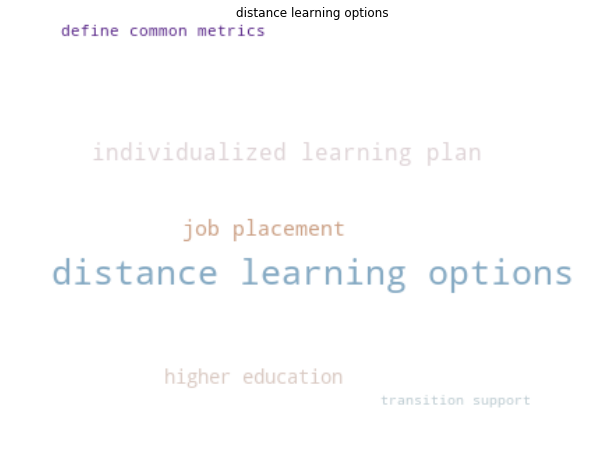

In [16]:
phrase_voter(test)